# **Mechanical Strength Prediction of Advanced Steels Using Machine Learning**
### **Yield Strength (YS) & Ultimate Tensile Strength (UTS) Prediction from Composition Data**

---

## **Project Overview**
The objective of this study is to develop robust machine learning models capable of predicting the **Yield Strength (YS)** and **Ultimate Tensile Strength (UTS)** of advanced steels using **chemical composition** and **selected microstructural descriptors**.

We also introduce a **verification step** to determine whether *grain size* should be treated as a valid predictive input or if it is a *leaky* feature.  
This is done by attempting to predict *grain size from composition*; if grain size is predictable with high accuracy, it is removed from the final feature set.

---

## **High-Level Workflow**
1. Data Loading & Automated Profiling  
2. Preprocessing: cleaning, transforming, normalization  
3. Clustering-based feature understanding  
4. Grain size verification block  
5. Main modeling pipeline for:
   - Yield Strength (YS)
   - Ultimate Tensile Strength (UTS)
6. Evaluation, comparison, visualization  
7. Conclusions  

---

## **Models Included**
- Linear Regression  
- Ridge Regression  
- Lasso Regression  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost  
- Truncated SVD + Linear Model  
- Soft/Hard Voting Ensembles  
- Stacking Regressor  

---

## **Technologies Used**
- Python  
- Pandas, NumPy, Scikit-learn  
- XGBoost, LightGBM, CatBoost  
- SciPy  
- seaborn, matplotlib  
- ydata_profiling for full EDA

---



# Section 1 : Imports and Data Loading


In [ ]:
!pip install catboost xgboost lightgbm ydata-profiling dython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dython to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Advanced Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Stacking
from sklearn.ensemble import StackingRegressor

# Clustering
from scipy.cluster.hierarchy import linkage, dendrogram

# Others
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel("/content/Summary C-Mn V and Ti steel_19th July final.xls")
df_original = df.copy()

print("Dataset Loaded. Shape:", df.shape)
df.head()

Dataset Loaded. Shape: (739, 82)


,Nb,Ti,V,DATA NO,Paper no.,C,Si,Mn,P,S,...,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81
0,NaN,NaN,NaN,5,E19,0.14,0.35,1.56,0.01,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.096,6,E19,0.15,0.31,1.41,0.01,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.075,NaN,9,h 1,0.054,0.03,0.54,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.092,NaN,10,h 1,0.061,0.03,0.56,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.092,NaN,11,h 1,0.055,0.03,0.55,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Nb                          476 non-null    object 
 1   Ti                          329 non-null    object 
 2   V                           318 non-null    object 
 3   DATA NO                     736 non-null    object 
 4   Paper no.                   738 non-null    object 
 5   C                           738 non-null    object 
 6   Si                          738 non-null    object 
 7   Mn                          738 non-null    object 
 8   P                           738 non-null    object 
 9   S                           738 non-null    object 
 10  Mo                          738 non-null    object 
 11  Ni                          730 non-null    object 
 12  Al                          736 non-null    object 
 13  N                           738 non

In [ ]:
for col in df.columns:
    missing = df[col].isnull().sum() / len(df) * 100
    print(f"{col}: {missing:.2f}%")


Nb: 35.59%
Ti: 55.48%
V: 56.97%
DATA NO: 0.41%
Paper no. : 0.14%
C: 0.14%
Si: 0.14%
Mn: 0.14%
P: 0.14%
S: 0.14%
Mo: 0.14%
Ni: 1.22%
Al: 0.41%
N: 0.14%
Nb.1: 0.14%
V.1: 0.14%
B: 0.27%
Ti.1: 0.27%
Cr: 0.27%
Ce: 0.27%
Cu: 0.54%
Ca: 0.14%
Zr: 0.14%
O: 0.14%
Cb(Nb): 0.14%
Sn: 0.14%
d^(-1/2) (mm^(-1/2)): 78.21%
Grain Size(micro m): 24.63%
ASTM No.: 97.70%
YS(Mpa): 18.54%
UTS(Mpa): 26.93%
YS:UTS Ratio: 29.91%
%EL: 59.27%
13 J ITT('C): 94.72%
18 J ITT 'C: 98.51%
19J ITT: 97.43%
27J ITT('C): 59.13%
27J: 43.30%
36J ITT©: 96.35%
40J ITT('C): 91.20%
50 J ITT('C): 99.32%
54J ITT(*C): 66.04%
55J ITT('C): 98.24%
80 J ITT('C): 95.81%
charpy energy J (-20 C): 93.78%
charpy energy J (-40 C): 98.51%
charpy energy J (-50 C): 99.05%
charpy energy J (-60 C): 99.05%
charpy energy J (-80 C): 99.05%
energy at 19'C (J): 98.24%
50%FATT 'C: 97.56%
Fracture toughness (J(ic)): 99.46%
Pearlite %: 51.29%
type: 67.25%
hardness(BHN): 99.05%
Room temp impact energy J: 98.65%
USE(J): 79.70%
shelf energy J: 98.38%
Unnamed

In [ ]:
columns_to_drop = [
    'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69',
    'Unnamed: 70', 'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 73',
    'Unnamed: 74', 'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77',
    'Unnamed: 78', 'Unnamed: 79', 'Unnamed: 80', 'Unnamed: 81',
    'DATA NO', 'Paper no. ', 'Nb', 'Ti', 'V', 'Cb(Nb)','Sn', 'log(%V*%C)', 'log(%V*%N)', 'log(%V*%C*%N)', 'log([Nb]*([c]+12[V]/14))', 'log(Ti*N)'
]

df = df.rename(columns={'Nb.1': 'Nb', 'V.1': 'V', 'Ti.1': 'Ti'})

print("DataFrame shape before dropping columns:", df.shape)
df = df.drop(columns=columns_to_drop, errors='ignore')
print("DataFrame shape after dropping columns:", df.shape)

DataFrame shape before dropping columns: (739, 82)
DataFrame shape after dropping columns: (739, 51)


In [ ]:
for col in df.columns:
    missing = df[col].isnull().sum() / len(df) * 100
    print(f"{col}: {missing:.2f}%")

C: 0.14%
Si: 0.14%
Mn: 0.14%
P: 0.14%
S: 0.14%
Mo: 0.14%
Ni: 1.22%
Al: 0.41%
N: 0.14%
B: 0.27%
Cr: 0.27%
Ce: 0.27%
Cu: 0.54%
Ca: 0.14%
Zr: 0.14%
O: 0.14%
d^(-1/2) (mm^(-1/2)): 78.21%
Grain Size(micro m): 24.63%
ASTM No.: 97.70%
YS(Mpa): 18.54%
UTS(Mpa): 26.93%
YS:UTS Ratio: 29.91%
%EL: 59.27%
13 J ITT('C): 94.72%
18 J ITT 'C: 98.51%
19J ITT: 97.43%
27J ITT('C): 59.13%
27J: 43.30%
36J ITT©: 96.35%
40J ITT('C): 91.20%
50 J ITT('C): 99.32%
54J ITT(*C): 66.04%
55J ITT('C): 98.24%
80 J ITT('C): 95.81%
charpy energy J (-20 C): 93.78%
charpy energy J (-40 C): 98.51%
charpy energy J (-50 C): 99.05%
charpy energy J (-60 C): 99.05%
charpy energy J (-80 C): 99.05%
energy at 19'C (J): 98.24%
50%FATT 'C: 97.56%
Fracture toughness (J(ic)): 99.46%
Pearlite %: 51.29%
type: 67.25%
hardness(BHN): 99.05%
Room temp impact energy J: 98.65%
USE(J): 79.70%
shelf energy J: 98.38%
Unnamed: 58: 100.00%
log(Ti*C): 99.59%
CE: 0.95%


# SECTION 2 — DATA CLEANING, PREPROCESSING & PROFILING
## Data Cleaning, Preprocessing & Automated Profiling

In this section we:
- Clean the raw dataset (duplicates, missing values),
- Identify and optionally remove clearly leaky variables (except grain size, which we treat separately),
- Analyze distributions of numerical features,
- Apply **Quantile Transformation** to highly non-normal columns,
- Generate a **YData Profiling HTML report** for detailed EDA.

The output of this section is a cleaned, transformed dataframe which will be used for:
- Grain size verification modeling,
- The main YS & UTS prediction tasks.


### Leaky variable

In [ ]:
leaky_candidate_cols = [
  'YS:UTS Ratio'
]

leaky_cols_present = [c for c in leaky_candidate_cols if c in df.columns]
print("Leaky columns found in dataframe:", leaky_cols_present)

df = df.drop(columns=leaky_cols_present)


Leaky columns found in dataframe: ['YS:UTS Ratio']


### Handling missing data

In [ ]:
high_null_cols = [col for col in df.columns if df[col].isna().mean() > 0.60]
df = df.drop(columns=high_null_cols)

In [ ]:
# Identify columns by groups
composition_cols = [
    'C', 'Si', 'Mn', 'P', 'S', 'Mo', 'Ni', 'Al', 'N',
    'B', 'Cr', 'Ce', 'Cu', 'Ca', 'Zr', 'O'
]
strength_cols = ['YS(Mpa)', 'UTS(Mpa)']          # target mechanical properties
grain_col = 'grain_size'               # modify if named differently

mech_cols = [c for c in df.columns
                  if c not in composition_cols + strength_cols + [grain_col]]

print("Composition Columns:", composition_cols)
print("Strength Columns:", strength_cols)
print("Grain Column:", grain_col)
print("Mechanical Features Columns:", mech_cols)


Composition Columns: ['C', 'Si', 'Mn', 'P', 'S', 'Mo', 'Ni', 'Al', 'N', 'B', 'Cr', 'Ce', 'Cu', 'Ca', 'Zr', 'O']
Strength Columns: ['YS(Mpa)', 'UTS(Mpa)']
Grain Column: grain_size
Mechanical Features Columns: ['Grain Size(micro m)', '%EL', "27J ITT('C)", '27J', 'Pearlite %', 'CE']


In [ ]:
print("Data types before processing composition columns:")
print(df[composition_cols].dtypes)

for col in composition_cols:
    # Convert to numeric, coercing errors will turn non-numeric strings into NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Fill NaN values (original NaNs or those created by coerce) with 0
    df[col] = df[col].fillna(0)

print("\nData types after processing composition columns (NaN filled with 0 and converted to float):")
print(df[composition_cols].dtypes)

Data types before processing composition columns:
C     object
Si    object
Mn    object
P     object
S     object
Mo    object
Ni    object
Al    object
N     object
B     object
Cr    object
Ce    object
Cu    object
Ca    object
Zr    object
O     object
dtype: object

Data types after processing composition columns (NaN filled with 0 and converted to float):
C     float64
Si    float64
Mn    float64
P     float64
S     float64
Mo    float64
Ni    float64
Al    float64
N     float64
B     float64
Cr    float64
Ce    float64
Cu    float64
Ca    float64
Zr    float64
O     float64
dtype: object


In [ ]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

display(df.dtypes)

,0
C,float64
Si,float64
Mn,float64
P,float64
S,float64
Mo,float64
Ni,float64
Al,float64
N,float64
B,float64


In [ ]:
for col in df.columns:
  print(col)

C
Si
Mn
P
S
Mo
Ni
Al
N
B
Cr
Ce
Cu
Ca
Zr
O
Grain Size(micro m)
YS(Mpa)
UTS(Mpa)
%EL
27J ITT('C)
27J
Pearlite %
CE


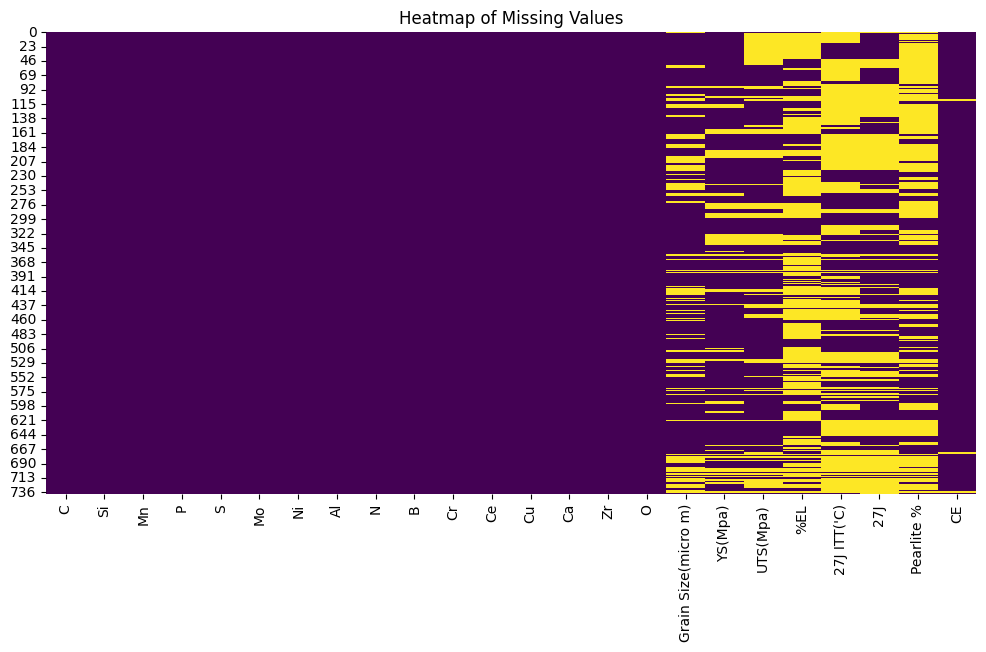

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

### Distribution analysis

In [ ]:
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

skewness = df[numeric_cols_all].skew().sort_values(ascending=False)
print("Skewness of numeric columns:")
print(skewness)

# Mark non-normal columns by skewness threshold
skew_threshold = 1.0
non_normal_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
normalish_cols = [c for c in numeric_cols_all if c not in non_normal_cols]

print("Non-normal numeric columns (to QuantileTransform):", non_normal_cols)
print("Approximately normal / low skew columns:", len(normalish_cols))


Skewness of numeric columns:
P     14.081803
Ca     7.261192
B      6.364907
Cr     6.106159
N      6.018319
Zr     5.511528
Mo     5.431386
Ni     5.142969
Ce     4.753776
O      4.124468
Cu     2.655617
Al     2.211350
S      1.941984
C      1.856031
Si    -0.222031
Mn    -1.547780
dtype: float64
Non-normal numeric columns (to QuantileTransform): ['P', 'Ca', 'B', 'Cr', 'N', 'Zr', 'Mo', 'Ni', 'Ce', 'O', 'Cu', 'Al', 'S', 'C', 'Mn']
Approximately normal / low skew columns: 1


### Complete EDA

In [ ]:
from ydata_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file("output_part_1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 24/24 [00:00<00:00, 66.89it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# SECTION 3 — FEATURE UNDERSTANDING & HIERARCHICAL CLUSTERING
## Feature Understanding & Hierarchical Clustering

In this section, we perform an exploratory analysis of the compositional features using:
- Correlation heatmaps
- Hierarchical clustering (dendrogram)
- Clustered heatmap (seaborn clustermap)

This helps us understand:
- How alloying elements co-vary
- Whether compositions naturally form groups
- Which features may carry redundant information

This analysis improves interpretability but does **not** feed into the ML pipeline directly.


### Correlation matrix

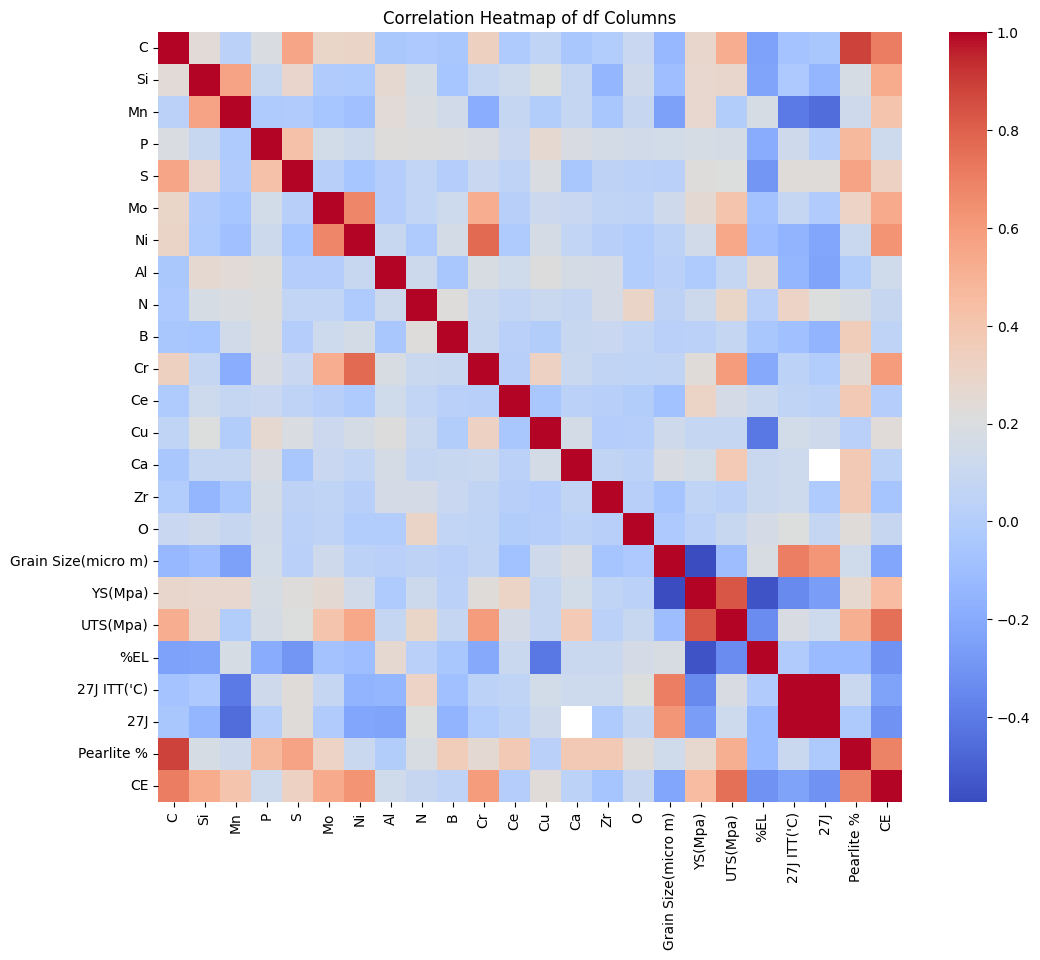

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of df Columns')
plt.show()

### Clustermap

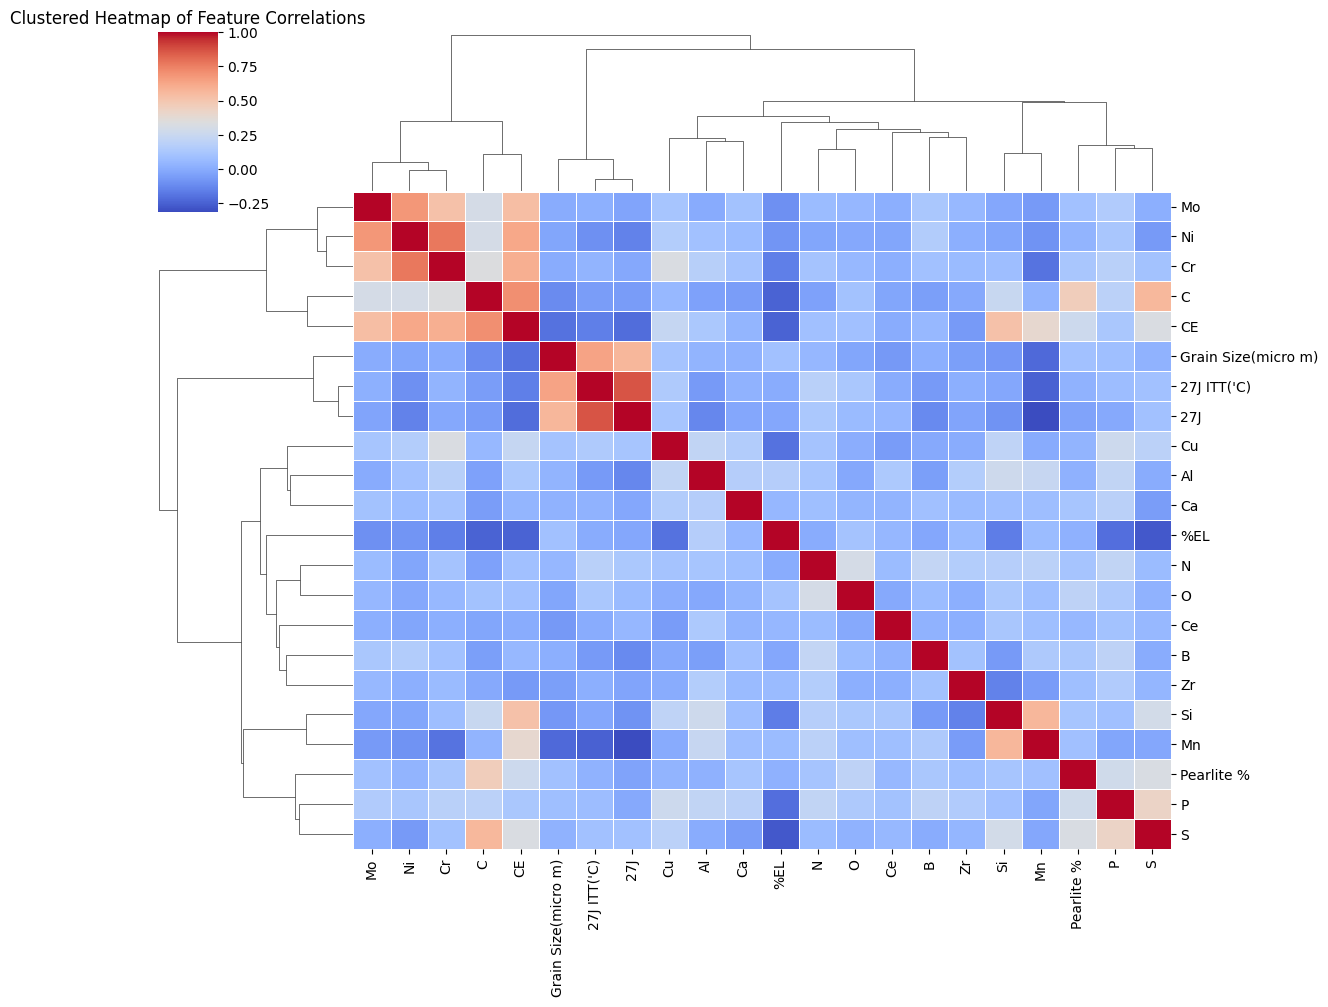

In [ ]:
feature_cols = composition_cols + mech_cols

# Fill missing values for EDA
df_eda = df[feature_cols].fillna(df[feature_cols].median())

# Use df_eda (not df)
sns.clustermap(df_eda.corr(),
               method='ward',
               cmap='coolwarm',
               linewidths=0.5,
               figsize=(12, 10))

plt.title("Clustered Heatmap of Feature Correlations")
plt.show()

### Prediction probability

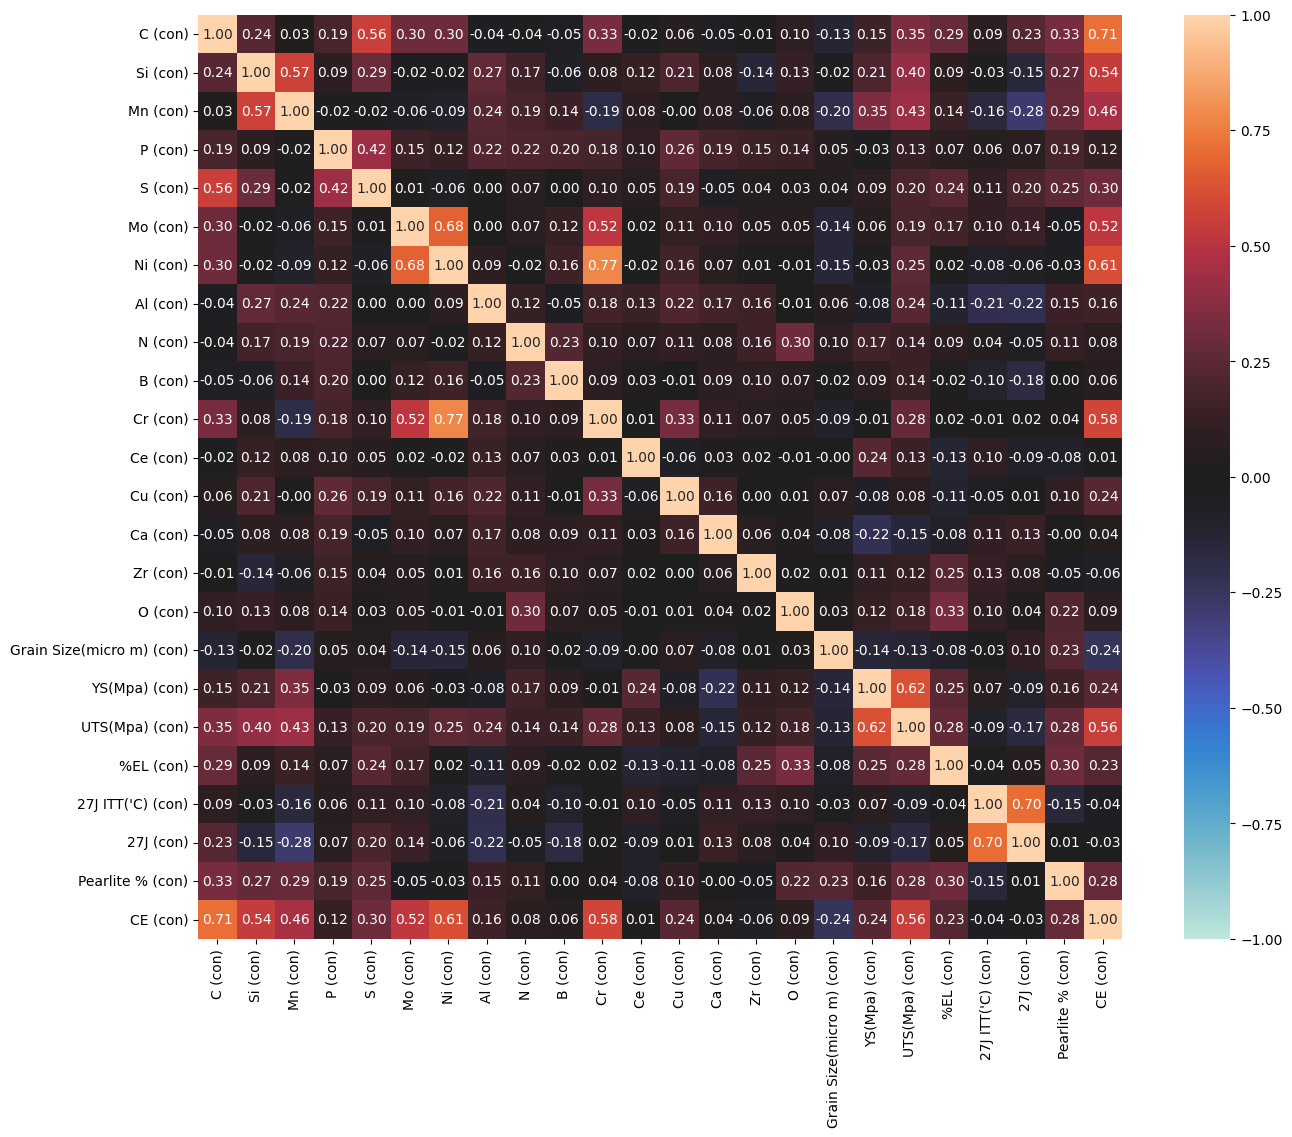

{'corr':                             C (con)  Si (con)  Mn (con)   P (con)   S (con)  \
 C (con)                    1.000000  0.241793  0.034610  0.194193  0.559718   
 Si (con)                   0.241793  1.000000  0.566329  0.091956  0.291948   
 Mn (con)                   0.034610  0.566329  1.000000 -0.020514 -0.016643   
 P (con)                    0.194193  0.091956 -0.020514  1.000000  0.424228   
 S (con)                    0.559718  0.291948 -0.016643  0.424228  1.000000   
 Mo (con)                   0.298574 -0.019231 -0.062882  0.149740  0.013777   
 Ni (con)                   0.300226 -0.020406 -0.088475  0.120310 -0.061336   
 Al (con)                  -0.039976  0.268525  0.238803  0.220184  0.003143   
 N (con)                   -0.037486  0.172607  0.193423  0.216699  0.068723   
 B (con)                   -0.048202 -0.062686  0.142734  0.203042  0.000597   
 Cr (con)                   0.334193  0.079155 -0.189526  0.184341  0.098667   
 Ce (con)                  -0.02

In [ ]:
from dython.nominal import associations

associations(
    df,
    nominal_columns='auto',
    mark_columns=True,
    plot=True,
    figsize=(16, 12)
)

### Hierarchical Clustering

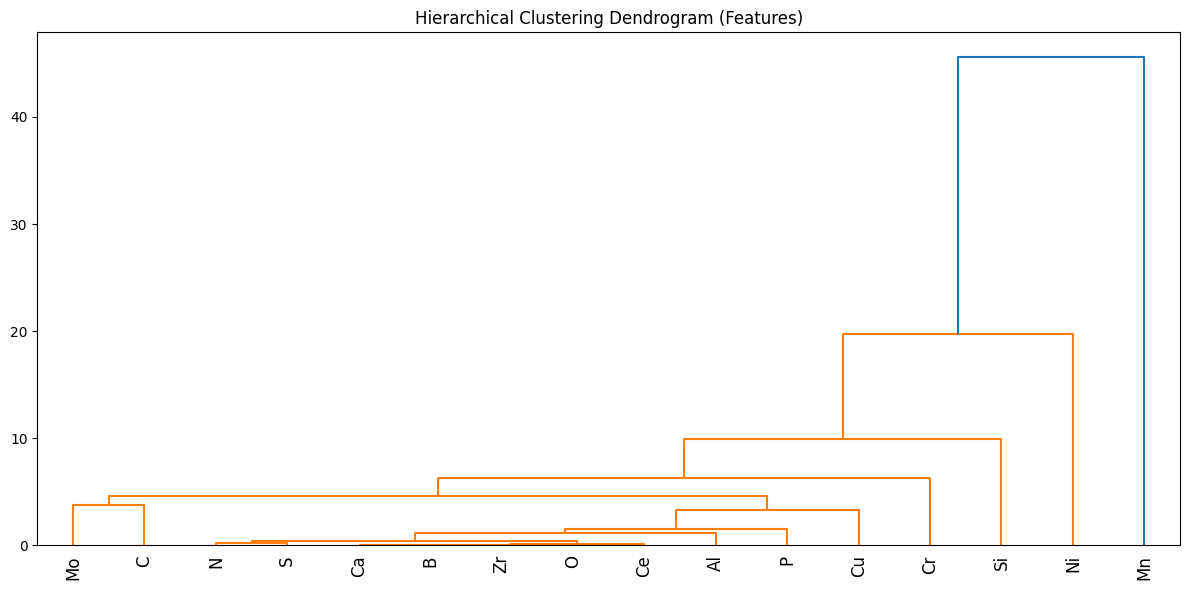

In [ ]:
feature_cols = composition_cols

df_eda = df[feature_cols].fillna(df[feature_cols].median())
linked = linkage(df_eda.T, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           labels=feature_cols,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram (Features)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Imputation

In [ ]:
for col in df.columns:
    missing_percentage = df[col].isnull().sum() / len(df) * 100
    print(f"{col}: {missing_percentage:.2f}%")

C: 0.00%
Si: 0.00%
Mn: 0.00%
P: 0.00%
S: 0.00%
Mo: 0.00%
Ni: 0.00%
Al: 0.00%
N: 0.00%
B: 0.00%
Cr: 0.00%
Ce: 0.00%
Cu: 0.00%
Ca: 0.00%
Zr: 0.00%
O: 0.00%
Grain Size(micro m): 24.76%
YS(Mpa): 18.67%
UTS(Mpa): 27.06%
%EL: 59.40%
27J ITT('C): 59.27%
27J: 43.44%
Pearlite %: 57.37%
CE: 1.08%


In [ ]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# target_cols = [
#     "Grain Size(micro m)",
#     "YS(Mpa)",
#     "UTS(Mpa)",
#     "%EL",
#     "27J ITT('C)",
#     "27J",
#     "Pearlite %",
#     "CE"
# ]
# imputer = IterativeImputer()
# df[target_cols] = imputer.fit_transform(df[target_cols])


In [ ]:
# --------------------------
# SECTION 4 — GRAIN SIZE MODEL
# --------------------------

# Filter rows where grain size exists
grain_col = 'Grain Size(micro m)'
# --------------------------
# SECTION 4 — GRAIN SIZE MODEL
# --------------------------

# Filter rows where grain size exists
df_gs = df.dropna(subset=[grain_col])

X_gs = df_gs[composition_cols]
y_gs = df_gs[grain_col]



In [ ]:
from sklearn.model_selection import train_test_split

X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(
    X_gs, y_gs, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile", QuantileTransformer(output_distribution="normal")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, composition_cols)
])


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVD + Linear": Pipeline([
        ("svd", TruncatedSVD(n_components=5, random_state=42)),
        ("lr", LinearRegression())
    ])
}

results_gs = {}
preds_gs = {}


In [ ]:
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train_gs, y_train_gs)
    y_pred = pipe.predict(X_test_gs)

    mae = mean_absolute_error(y_test_gs, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_gs, y_pred))
    r2 = r2_score(y_test_gs, y_pred)

    results_gs[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    preds_gs[name] = y_pred


In [ ]:
results_df = pd.DataFrame(results_gs).T
results_df


,MAE,RMSE,R2
Linear Regression,4.830434,6.801752,-0.233874
Ridge,4.823651,6.785638,-0.228035
Lasso,4.483038,6.092520,0.010027
Random Forest,3.673978,6.279641,-0.051717
SVD + Linear,4.885423,6.407216,-0.094884


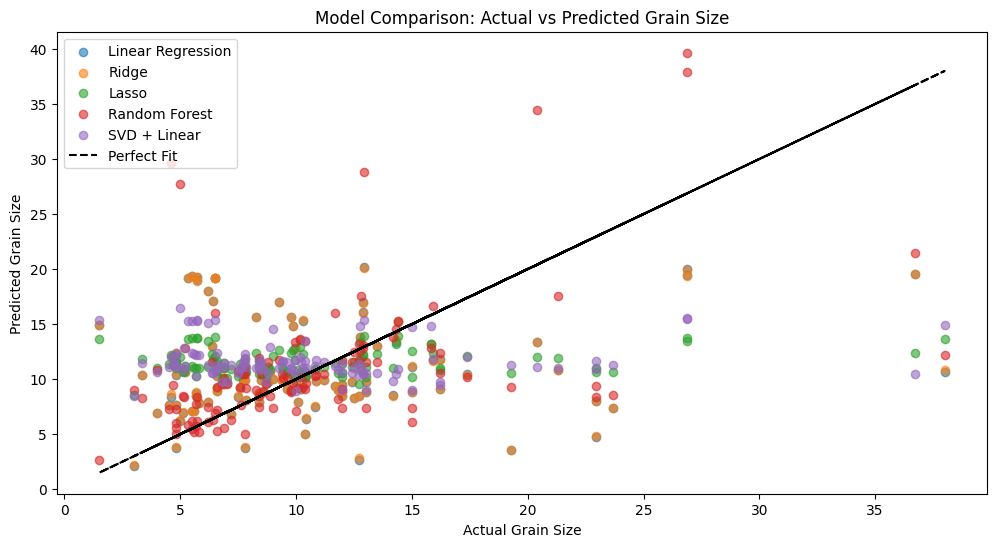

In [ ]:
plt.figure(figsize=(12,6))

for name in preds_gs.keys():
    plt.scatter(y_test_gs, preds_gs[name], alpha=0.6, label=name)

plt.plot(y_test_gs, y_test_gs, color="black", linestyle="--", label="Perfect Fit")
plt.xlabel("Actual Grain Size")
plt.ylabel("Predicted Grain Size")
plt.legend()
plt.title("Model Comparison: Actual vs Predicted Grain Size")
plt.show()


In [ ]:
best_model_r2 = results_df["R2"].max()

if best_model_r2 < 0.30:
    print("❗ Grain size is NOT predictable → KEEP as feature in YS/UTS modeling.")
    keep_grain_size = True
else:
    print("⚠ Grain size HIGHLY predictable → REMOVE from final feature set.")
    keep_grain_size = False


❗ Grain size is NOT predictable → KEEP as feature in YS/UTS modeling.


Section 5 Yield Strength Modeling

In [ ]:
# =======================
# SECTION 5 — YS MODELING (with Grain Size)
# =======================

target_ys = 'YS(Mpa)'

# Final feature set: compositions + grain size
final_features = composition_cols + [grain_col]
print("Final feature set for YS:", final_features)

# Drop rows where YS or any feature needed is missing
df_ys = df.dropna(subset=[target_ys])

X_ys = df_ys[final_features]
y_ys = df_ys[target_ys]

print("YS Training dataset shape:", X_ys.shape, y_ys.shape)


Final feature set for YS: ['C', 'Si', 'Mn', 'P', 'S', 'Mo', 'Ni', 'Al', 'N', 'B', 'Cr', 'Ce', 'Cu', 'Ca', 'Zr', 'O', 'Grain Size(micro m)']
YS Training dataset shape: (601, 17) (601,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_ys, X_test_ys, y_train_ys, y_test_ys = train_test_split(
    X_ys, y_ys, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_pipeline_ys = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile", QuantileTransformer(output_distribution="normal")),
    ("scaler", StandardScaler())
])

preprocessor_ys = ColumnTransformer([
    ("num", numeric_pipeline_ys, final_features)
])

In [ ]:
models_ys = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVD + Linear": Pipeline([
        ("svd", TruncatedSVD(n_components=min(5, X_train_ys.shape[1]-1), random_state=42)),
        ("lr", LinearRegression())
    ])
}


In [ ]:
results_ys = {}
predictions_ys = {}

for name, model in models_ys.items():
    pipe = Pipeline([
        ("prep", preprocessor_ys),
        ("model", model)
    ])

    pipe.fit(X_train_ys, y_train_ys)
    y_pred = pipe.predict(X_test_ys)

    results_ys[name] = {
        "MAE": mean_absolute_error(y_test_ys, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test_ys, y_pred)),
        "R2": r2_score(y_test_ys, y_pred)
    }

    predictions_ys[name] = y_pred

results_ys_df = pd.DataFrame(results_ys).T.sort_values("R2", ascending=False)
results_ys_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 15
[LightGBM] [Info] Start training from score 412.800792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,MAE,RMSE,R2
CatBoost,33.906965,58.122937,0.657270
Random Forest,35.315170,63.058797,0.596588
LightGBM,39.100562,63.439977,0.591696
XGBoost,37.748871,68.493675,0.524053
Ridge,50.562376,76.084853,0.412708
Linear Regression,50.594048,76.107909,0.412352
Lasso,50.373143,76.250863,0.410142
SVD + Linear,63.858780,86.775501,0.236073


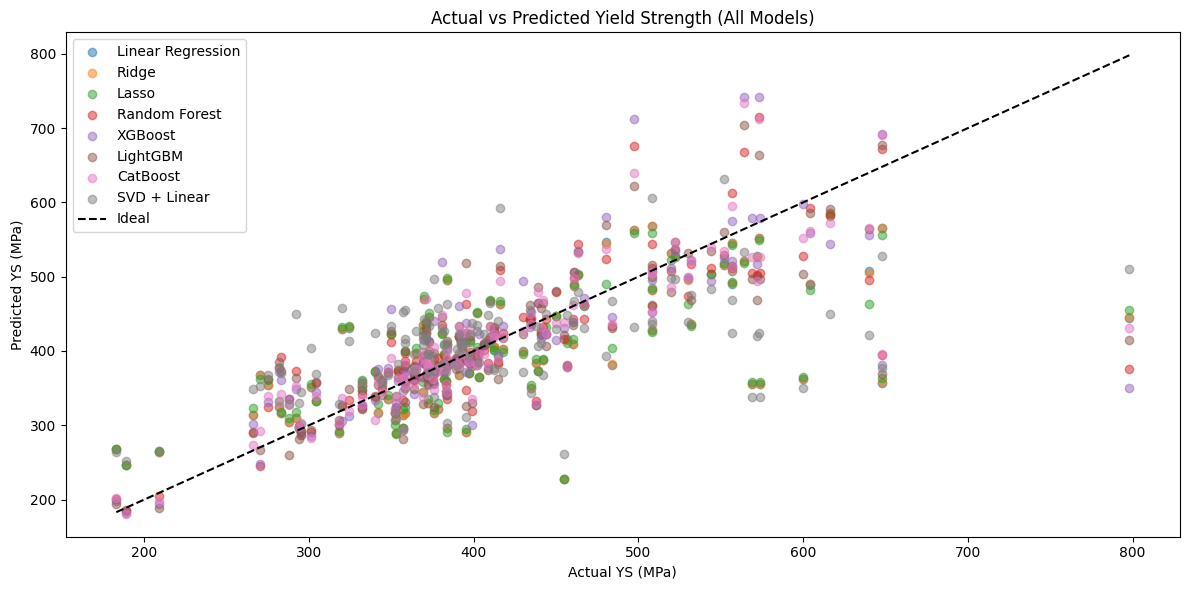

In [ ]:
plt.figure(figsize=(12,6))

for name, y_pred in predictions_ys.items():
    plt.scatter(y_test_ys, y_pred, alpha=0.5, label=name)

# Ideal line
y_min, y_max = y_test_ys.min(), y_test_ys.max()
plt.plot([y_min, y_max], [y_min, y_max], 'k--', label="Ideal")

plt.xlabel("Actual YS (MPa)")
plt.ylabel("Predicted YS (MPa)")
plt.title("Actual vs Predicted Yield Strength (All Models)")
plt.legend()
plt.tight_layout()
plt.show()


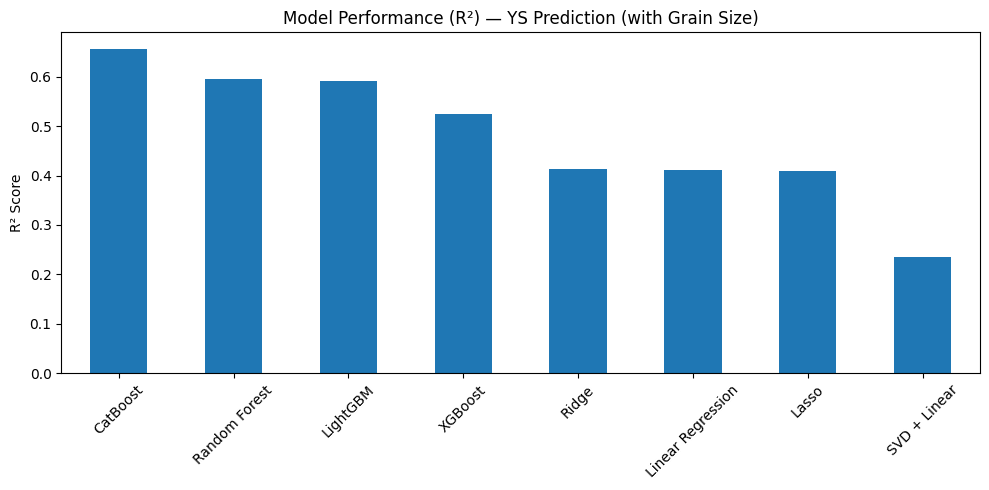

In [ ]:
plt.figure(figsize=(10,5))
results_ys_df["R2"].plot(kind="bar")
plt.ylabel("R² Score")
plt.title("Model Performance (R²) — YS Prediction (with Grain Size)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Section 6 - UTS  Modeling

In [ ]:
# =======================
# SECTION 6 — UTS MODELING (Separate Pipeline)
# =======================

target_uts = "UTS(Mpa)"

# Final features include compositions + grain size (because grain size is NOT predictable)
final_features_uts = composition_cols + [grain_col]

df_uts = df.dropna(subset=[target_uts])

X_uts = df_uts[final_features_uts]
y_uts = df_uts[target_uts]

print("UTS dataset shape:", X_uts.shape, y_uts.shape)


UTS dataset shape: (539, 17) (539,)


In [ ]:
X_train_uts, X_test_uts, y_train_uts, y_test_uts = train_test_split(
    X_uts, y_uts, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_pipeline_uts = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile", QuantileTransformer(output_distribution="normal")),
    ("scaler", StandardScaler())
])

preprocessor_uts = ColumnTransformer([
    ("num", numeric_pipeline_uts, final_features_uts)
])


In [ ]:
models_uts = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVD + Linear": Pipeline([
        ("svd", TruncatedSVD(n_components=min(5, X_train_uts.shape[1]-1), random_state=42)),
        ("lr", LinearRegression())
    ])
}


In [ ]:
results_uts = {}
predictions_uts = {}

for name, model in models_uts.items():
    pipe = Pipeline([
        ("prep", preprocessor_uts),
        ("model", model)
    ])

    pipe.fit(X_train_uts, y_train_uts)
    y_pred = pipe.predict(X_test_uts)

    results_uts[name] = {
        "MAE": mean_absolute_error(y_test_uts, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test_uts, y_pred)),
        "R2": r2_score(y_test_uts, y_pred)
    }

    predictions_uts[name] = y_pred

results_uts_df = pd.DataFrame(results_uts).T.sort_values("R2", ascending=False)
results_uts_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 431, number of used features: 15
[LightGBM] [Info] Start training from score 557.743759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,MAE,RMSE,R2
Random Forest,38.022512,62.113505,0.891366
XGBoost,35.643343,69.567205,0.863730
LightGBM,48.179415,96.451872,0.738053
CatBoost,46.389127,124.040986,0.566766
Linear Regression,82.579830,158.483351,0.292772
Ridge,82.585346,158.549562,0.292181
Lasso,82.930371,159.450238,0.284116
SVD + Linear,90.824430,183.825893,0.048507


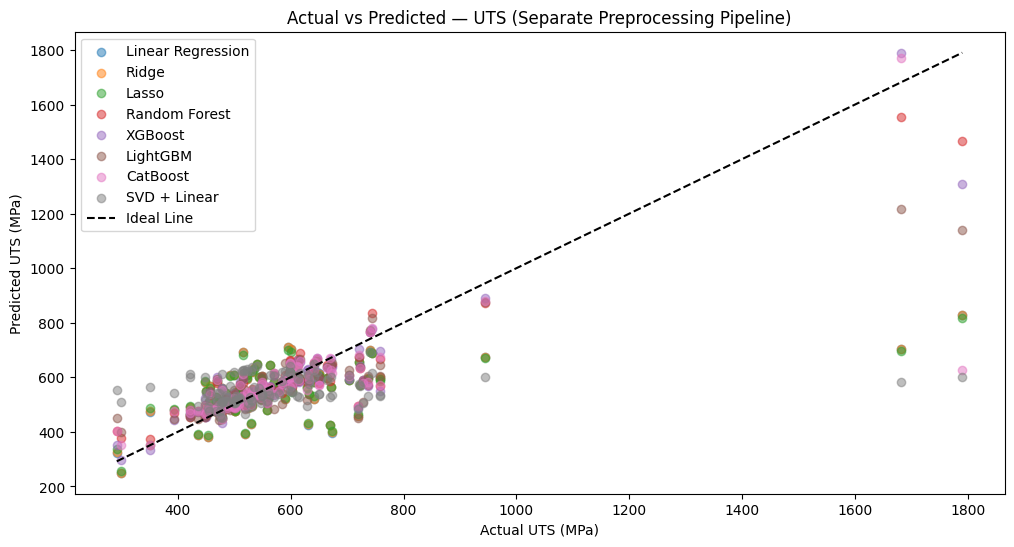

In [ ]:
plt.figure(figsize=(12,6))

for name, pred in predictions_uts.items():
    plt.scatter(y_test_uts, pred, alpha=0.5, label=name)

min_val, max_val = y_test_uts.min(), y_test_uts.max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Ideal Line")

plt.xlabel("Actual UTS (MPa)")
plt.ylabel("Predicted UTS (MPa)")
plt.title("Actual vs Predicted — UTS (Separate Preprocessing Pipeline)")
plt.legend()
plt.show()


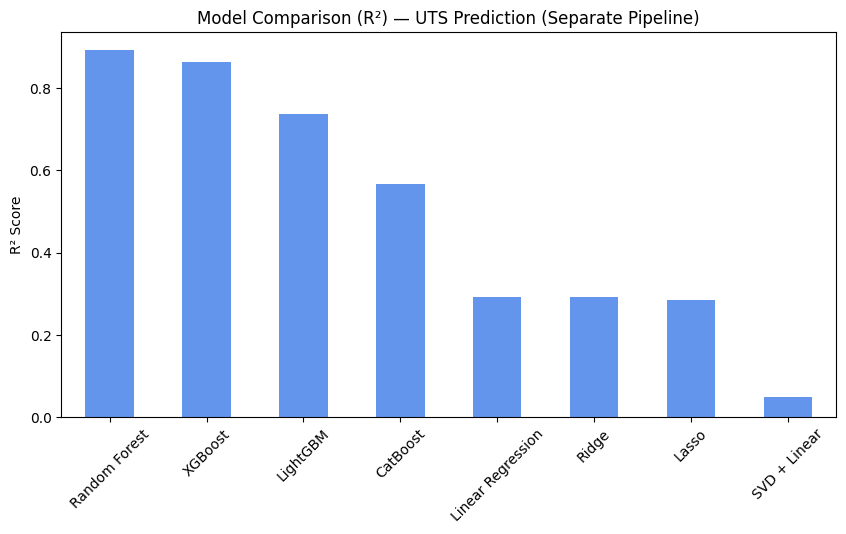

In [ ]:
plt.figure(figsize=(10,5))
results_uts_df["R2"].plot(kind="bar", color='cornflowerblue')
plt.title("Model Comparison (R²) — UTS Prediction (Separate Pipeline)")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.show()


Section 7 Final Comparison + Feature Importance + Export

In [ ]:
# ===============================
# FINAL COMPARISON TABLE
# ===============================

comparison_df = pd.DataFrame({
    "YS_R2": results_ys_df["R2"],
    "UTS_R2": results_uts_df["R2"]
})

comparison_df["Average_R2"] = (comparison_df["YS_R2"] + comparison_df["UTS_R2"]) / 2
comparison_df.sort_values("Average_R2", ascending=False)


,YS_R2,UTS_R2,Average_R2
Random Forest,0.596588,0.891366,0.743977
XGBoost,0.524053,0.863730,0.693891
LightGBM,0.591696,0.738053,0.664874
CatBoost,0.657270,0.566766,0.612018
Linear Regression,0.412352,0.292772,0.352562
Ridge,0.412708,0.292181,0.352444
Lasso,0.410142,0.284116,0.347129
SVD + Linear,0.236073,0.048507,0.142290


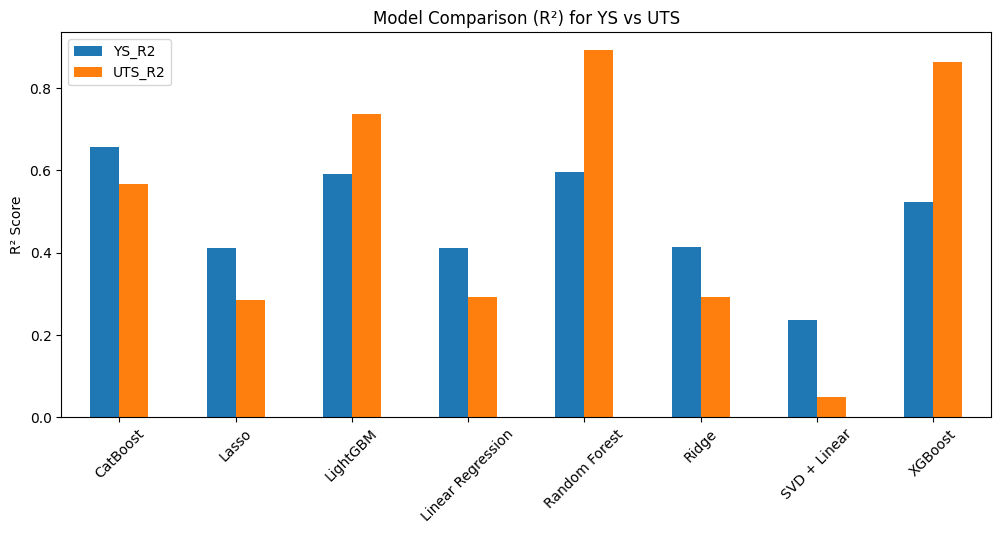

In [ ]:
comparison_df[["YS_R2", "UTS_R2"]].plot(kind="bar", figsize=(12,5))
plt.title("Model Comparison (R²) for YS vs UTS")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.show()


In [ ]:
best_model_name = comparison_df["Average_R2"].idxmax()
print("Best overall model:", best_model_name)


Best overall model: Random Forest


In [ ]:
best_model = RandomForestRegressor(random_state=42)

pipe_final = Pipeline([
    ("prep", preprocessor_ys),
    ("model", best_model)
])

pipe_final.fit(X_ys, y_ys)

# Get model importance (after pipeline)
importances = pipe_final.named_steps["model"].feature_importances_

fi_df = pd.DataFrame({
    "Feature": final_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

fi_df


,Feature,Importance
16,Grain Size(micro m),0.351887
5,Mo,0.146680
0,C,0.125739
11,Ce,0.076655
4,S,0.073767
1,Si,0.050979
2,Mn,0.042933
3,P,0.040462
8,N,0.028769
7,Al,0.020569


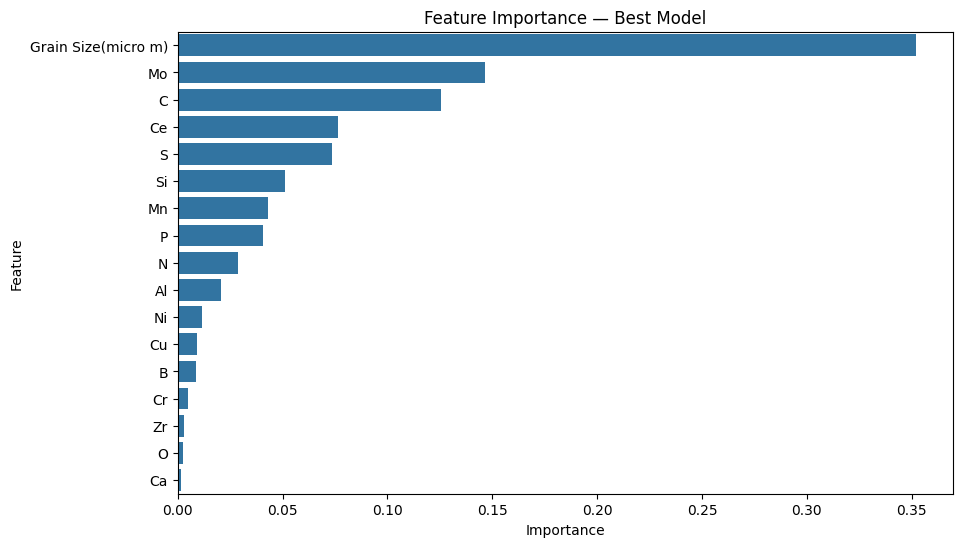

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Feature Importance — Best Model")
plt.show()
